<a href="https://colab.research.google.com/github/dmill166/datamining-learning/blob/main/Songs_Classifier_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preamble**

**Title**: *Spotify Song Tracks Classifier*

**Author**: *Dakota M. Miller*

**Email**: *dmil166 @ msudenver.edu*

**Last Update**: *2021-11-14*

# **Introduction**

The goal of this analysis is to develop classification models capable of predicting the genre of a song based on measured audio attributes.


# **Dataset**

The dataset for this project is available under 'data' (genres_v2.csv) and it was obtained from [Kaggle](https://www.kaggle.com/mrmorj/dataset-of-songs-in-spotify). It consists of a collection of 42,305 song track from various musical genres, with the following audio attributes:

* danceability
* energy
* key
* loudness
* speechiness
* acousticness
* instrumentalness
* liveness
* valence
* tempo
* duration_ms

The meaning of those audio attributes are described by Spotify [here](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features).

```
[
danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,song_name,Unnamed: 0,title
0.831,0.8140000000000001,2,-7.364,1,0.42,0.0598,0.0134,0.0556,0.389,156.985,audio_features,2Vc6NJ9PW9gD9q343XFRKx,spotify:track:2Vc6NJ9PW9gD9q343XFRKx,https://api.spotify.com/v1/tracks/2Vc6NJ9PW9gD9q343XFRKx,https://api.spotify.com/v1/audio-analysis/2Vc6NJ9PW9gD9q343XFRKx,124539,4,Dark Trap,Mercury: Retrograde,,
0.7190000000000001,0.493,8,-7.23,1,0.0794,0.401,0.0,0.11800000000000001,0.124,115.08,audio_features,7pgJBLVz5VmnL7uGHmRj6p,spotify:track:7pgJBLVz5VmnL7uGHmRj6p,https://api.spotify.com/v1/tracks/7pgJBLVz5VmnL7uGHmRj6p,https://api.spotify.com/v1/audio-analysis/7pgJBLVz5VmnL7uGHmRj6p,224427,4,Dark Trap,Pathology,,
.
.
.
0.529,0.945,9,-5.862,1,0.0615,0.00189,5.45e-05,0.414,0.134,155.047,audio_features,6MAAMZImxcvYhRnxDLTufD,spotify:track:6MAAMZImxcvYhRnxDLTufD,https://api.spotify.com/v1/tracks/6MAAMZImxcvYhRnxDLTufD,https://api.spotify.com/v1/audio-analysis/6MAAMZImxcvYhRnxDLTufD,162161,4,hardstyle,,20999.0,Best of Hardstyle 2020
]
```

# **Configuration & Data Collection**

## Library Imports

In [1]:
import csv
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
from numpy import ravel                                  # For matrices
import os
import pandas as pd
import requests
import seaborn as sb
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.feature_selection import VarianceThreshold # Feature selector
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB #Import Gaussian Naive Bayes model
from sklearn.neighbors import KNeighborsClassifier    # The k-nearest neighbor classifier
from sklearn.pipeline import Pipeline                                  # For setting up pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
import statistics as stats
import sys

## Definitions/Parameters


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


## Resources

*   [Learn how to import files into Google Colab](https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971)
*   [Troubleshoot dropping dataframe columns](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) and [again](https://stackoverflow.com/questions/38288372/unable-to-drop-a-column-from-pandas-dataframe)
*   [Affect a column of a dataframe with a function](https://stackoverflow.com/questions/34962104/how-can-i-use-the-apply-function-for-a-single-column)
*   [Extracting unique values and positions from NumPy Array](https://numpy.org/doc/stable/reference/generated/numpy.unique.html)
*   [Used a mix of this site and another I can't find now to figure how to split into multiple sub-arrays based on genre](https://numpy.org/devdocs/reference/generated/numpy.unique.html)
*   [Located resource to accurately express myself during this project](https://looks.wtf/flipping-tables)
*   [Researched transpose function for iterative collection building](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.transpose.html)
*   [Leveraged NumPy to calculate attribute statistics, including q1 and q3](https://numpy.org/doc/stable/reference/generated/numpy.quantile.html)
*   [Found online guide and modified approach to generate list of outliers](https://blog.finxter.com/how-to-find-outliers-in-python-easily/)
*   Coworker suggestion to use pandas for the histogram production and seaborn library for correlation analysis
    * [Seaborn pairplot documentation](https://seaborn.pydata.org/generated/seaborn.pairplot.html)
*   [Refresher on classification](https://www.geeksforgeeks.org/multiclass-classification-using-scikit-learn/)
    * [Decision Tree Classification Demonstration](https://www.datacamp.com/community/tutorials/decision-tree-classification-python)
    * [Naive Bayes Classification Demonstration](https://www.datacamp.com/community/tutorials/naive-bayes-scikit-learn)
    * Used In-Class Assignment 21 for the approach to Artificial Neural Network
    * [Modeled KNN model similar to IBM example](https://developer.ibm.com/tutorials/learn-classification-algorithms-using-python-and-scikit-learn/)
    * [Read about pipelines and how they fit/transform data in a compact manner](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
    * [KNN Classifier documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
    * [Online illustration of KNN combined with pipelining](https://machinelearningmastery.com/modeling-pipeline-optimization-with-scikit-learn/)
    * [Awesome explanation of KNN Classification and Pipelining](https://medium.com/analytics-vidhya/beginners-guide-to-k-nearest-neighbors-pipelines-in-classification-704b87f534e2)

# **Preprocessing**

This section should contain one or more markdown text with supporting code explaining how the dataset was processed before the analysis, including attributes removal, attributes enconding, and any transformations perfomed in the original dataset.


## Specific Preprocessing:
* Remove column 'type'
    * This column only had one value across all records and would not offer meaningful progress towards classification
* Remove columns 'id', 'uri', 'track_href', 'analysis_url', 'song_name', 'Unnamed: 0', 'title'
    * Many of these are either unique identifiers or offer other meaning (such as locations on the web) that should not be used for classification purposes
* Prepared data for use in Summary Statistics as well as boxplot generation through list comprehension and iteration

In [3]:
# Read in csv as pandas dataframe
spotify_df = pd.read_csv('/content/drive/My Drive/genres_v2.csv')

# Delete unnecessary columns
spotify_df.drop(columns=['type', 'id', 'uri', 'track_href', 'analysis_url', 'time_signature', 'song_name', 'Unnamed: 0', 'title'], axis=1, inplace=True)

# Capture column headers into a Python list
col_headers = spotify_df.columns.to_list()
attr_headers = col_headers[0:-1]

# Capitalize genres, then sort dataframe by this column. Extract unique list of genres
spotify_df['genre'] = spotify_df['genre'].map(lambda genre: genre.upper())
genres_list = list(spotify_df['genre'].unique())
genres_list.sort()
spotify_df.sort_values('genre', inplace=True)

# Convert data to NumPy Array and confirm genre sorting is still in place
spotify_nparray = spotify_df.to_numpy()

# Capture unique genres (mainly for indices)
genres_nparray, indices = np.unique(spotify_nparray[:, -1], return_index=True)

# Split large NumPy Array into sub-arrays by genre
genres_nparray_list = np.array_split(spotify_nparray, indices)
all_genres_nparrays_list = []
for x in genres_nparray_list[1:]:
  all_genres_nparrays_list.append(np.array(x))

# Pivot genre sub-array for each attribute,
# Append results to list of lists of values (attribute lists of genre lists of metric data)
genre_attr_index = 0
all_attribute_genre_data = [[ [] for _ in range(len(genres_list)) ] for _ in range (len(attr_headers)) ]
# histogram_attribute_lists2 = [[] for _ in all_attribute_genre_data] #approach to simplify aggregations into one pass over the data

# Generates transposed data for purposes of boxplot iteration
for a in all_genres_nparrays_list:
  attr_iter_index = 0 
  metrics = all_genres_nparrays_list[genre_attr_index]
  for row in metrics.transpose()[:-1]:
    all_attribute_genre_data[attr_iter_index][genre_attr_index] = list(row)
    # histogram_attribute_lists2[attr_iter_index].append(list(row))
    attr_iter_index += 1
  genre_attr_index += 1

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# **Summary Statistics, Boxplots, and Histograms**

this section should present the python code that displays summary statistics and visuals from each of the attributes of the dataset; at minimum, a histogram and a multi box plot (per genre) should be produce per attribute.


## Summary Stats


In [4]:
# Establish indices for iterating in summary statistic production
col_index = 0
genre_index = 0

# Iterate through each genre set of attributes
while genre_index < len(all_genres_nparrays_list):
  print('\n\nSUMMARY STATISTICS FOR', genres_list[genre_index], '\n')
  current_genre_nparray = all_genres_nparrays_list[genre_index]
  genre_outliers_tuple = []
  
  # For each attribute, calculate and output summary statistics
  while col_index < (len(col_headers) - 1): #remove 1 for genres
    temp_array = current_genre_nparray[:, col_index]
    current_attribute = col_headers[col_index].upper()
    print('*** Summary Statistics of Attribute: ' + current_attribute + ' ***')
    attribute_min = '{:,.3f}'.format(np.min(temp_array))
    attribute_max = '{:,.3f}'.format(np.max(temp_array))
    print(f'{current_attribute} Range: [{attribute_min} , {attribute_max}]')
    attribute_mean = '{:,.3f}'.format(np.mean(temp_array))
    print(f'{current_attribute} Mean: {attribute_mean}')
    attribute_median = '{:,.3f}'.format(np.median(temp_array))
    print(f'{current_attribute} Median: {attribute_median}')
    attribute_std = '{:,.3f}'.format(np.std(temp_array))
    print(f'{current_attribute} StD: {attribute_std}')
    col_index += 1
  genre_index += 1
  col_index = 0



SUMMARY STATISTICS FOR DARK TRAP 

*** Summary Statistics of Attribute: DANCEABILITY ***
DANCEABILITY Range: [0.098 , 0.985]
DANCEABILITY Mean: 0.619
DANCEABILITY Median: 0.625
DANCEABILITY StD: 0.161
*** Summary Statistics of Attribute: ENERGY ***
ENERGY Range: [0.000 , 0.998]
ENERGY Mean: 0.647
ENERGY Median: 0.650
ENERGY StD: 0.181
*** Summary Statistics of Attribute: KEY ***
KEY Range: [0.000 , 11.000]
KEY Mean: 5.298
KEY Median: 6.000
KEY StD: 3.638
*** Summary Statistics of Attribute: LOUDNESS ***
LOUDNESS Range: [-25.222 , 1.646]
LOUDNESS Mean: -7.998
LOUDNESS Median: -7.678
LOUDNESS StD: 3.157
*** Summary Statistics of Attribute: MODE ***
MODE Range: [0.000 , 1.000]
MODE Mean: 0.536
MODE Median: 1.000
MODE StD: 0.499
*** Summary Statistics of Attribute: SPEECHINESS ***
SPEECHINESS Range: [0.024 , 0.946]
SPEECHINESS Mean: 0.123
SPEECHINESS Median: 0.065
SPEECHINESS StD: 0.123
*** Summary Statistics of Attribute: ACOUSTICNESS ***
ACOUSTICNESS Range: [0.000 , 0.984]
ACOUSTICNESS

## Boxplots

data: [[0.831, 0.591, 0.6459999999999999, 0.265, 0.57, 0.602, 0.474, 0.397, 0.574, 0.578, 0.757, 0.631, 0.728, 0.762, 0.752, 0.636, 0.486, 0.507, 0.16, 0.608, 0.51, 0.52, 0.505, 0.506, 0.34600000000000003, 0.56, 0.4920000000000001, 0.421, 0.387, 0.628, 0.158, 0.636, 0.508, 0.6940000000000001, 0.443, 0.358, 0.754, 0.65, 0.8859999999999999, 0.55, 0.654, 0.7659999999999999, 0.62, 0.637, 0.621, 0.626, 0.503, 0.825, 0.614, 0.386, 0.675, 0.383, 0.629, 0.5429999999999999, 0.639, 0.603, 0.583, 0.31, 0.563, 0.64, 0.711, 0.5529999999999999, 0.529, 0.588, 0.618, 0.544, 0.358, 0.637, 0.469, 0.493, 0.375, 0.4320000000000001, 0.5770000000000001, 0.67, 0.807, 0.5820000000000001, 0.6409999999999999, 0.72, 0.636, 0.457, 0.607, 0.687, 0.6609999999999999, 0.645, 0.479, 0.591, 0.682, 0.621, 0.568, 0.636, 0.653, 0.472, 0.58, 0.608, 0.446, 0.536, 0.687, 0.619, 0.513, 0.624, 0.547, 0.631, 0.7120000000000001, 0.502, 0.603, 0.595, 0.425, 0.573, 0.528, 0.383, 0.5660000000000001, 0.772, 0.547, 0.505, 0.461, 0.27

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


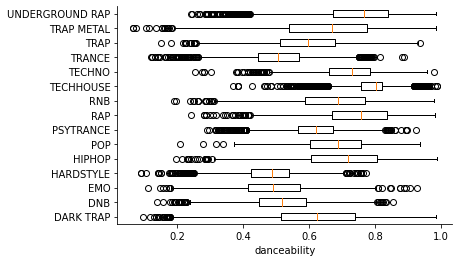

data: [[0.8140000000000001, 0.7240000000000001, 0.5579999999999999, 0.713, 0.7709999999999999, 0.569, 0.677, 0.607, 0.7490000000000001, 0.589, 0.915, 0.708, 0.5660000000000001, 0.459, 0.421, 0.853, 0.5, 0.972, 0.0944, 0.5870000000000001, 0.925, 0.8740000000000001, 0.7829999999999999, 0.86, 0.41, 0.696, 0.838, 0.818, 0.855, 0.925, 0.489, 0.818, 0.8170000000000001, 0.691, 0.8220000000000001, 0.305, 0.298, 0.254, 0.298, 0.294, 0.304, 0.152, 0.301, 0.343, 0.34700000000000003, 0.415, 0.359, 0.417, 0.485, 0.255, 0.454, 0.736, 0.327, 0.292, 0.728, 0.35700000000000004, 0.479, 0.541, 0.431, 0.65, 0.181, 0.755, 0.619, 0.464, 0.617, 0.446, 0.24, 0.191, 0.511, 0.7170000000000001, 0.79, 0.815, 0.6509999999999999, 0.769, 0.575, 0.733, 0.63, 0.461, 0.713, 0.698, 0.726, 0.736, 0.602, 0.383, 0.8420000000000001, 0.563, 0.601, 0.872, 0.594, 0.6940000000000001, 0.585, 0.7040000000000001, 0.598, 0.718, 0.593, 0.929, 0.736, 0.706, 0.447, 0.8390000000000001, 0.934, 0.5820000000000001, 0.6709999999999999, 0.5

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


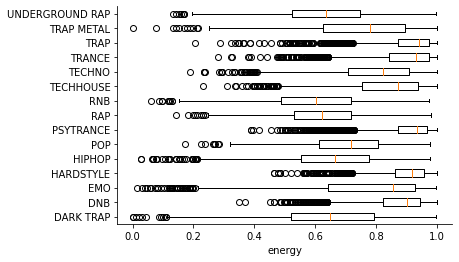

data: [[2, 0, 0, 6, 9, 9, 9, 1, 9, 11, 7, 1, 11, 2, 2, 3, 10, 8, 9, 9, 11, 9, 10, 10, 1, 0, 6, 7, 11, 8, 1, 1, 6, 10, 8, 4, 7, 4, 8, 11, 0, 8, 8, 7, 11, 0, 6, 11, 5, 8, 0, 11, 1, 9, 11, 11, 1, 4, 11, 0, 2, 9, 1, 0, 4, 6, 7, 2, 1, 10, 7, 9, 9, 9, 9, 9, 0, 7, 11, 11, 11, 11, 0, 0, 9, 7, 9, 9, 0, 9, 9, 3, 8, 10, 6, 5, 11, 8, 9, 9, 9, 9, 10, 5, 9, 4, 2, 3, 3, 9, 10, 6, 4, 9, 9, 5, 6, 6, 2, 10, 3, 2, 4, 9, 5, 4, 11, 8, 6, 2, 11, 7, 11, 9, 11, 4, 1, 11, 9, 1, 11, 5, 2, 1, 8, 0, 1, 10, 6, 10, 11, 10, 8, 1, 10, 7, 8, 6, 8, 1, 9, 4, 9, 4, 11, 5, 4, 6, 3, 10, 8, 4, 7, 4, 11, 0, 0, 4, 10, 7, 11, 7, 9, 4, 5, 9, 11, 1, 9, 1, 8, 3, 10, 9, 1, 8, 6, 10, 1, 2, 0, 6, 3, 9, 8, 8, 6, 9, 6, 9, 7, 4, 11, 10, 3, 11, 7, 0, 9, 2, 6, 10, 7, 6, 0, 10, 5, 5, 10, 8, 5, 8, 1, 7, 6, 7, 9, 11, 8, 5, 8, 1, 10, 8, 6, 1, 4, 10, 7, 5, 4, 8, 7, 11, 5, 1, 6, 8, 8, 9, 4, 0, 1, 10, 1, 8, 3, 6, 5, 5, 9, 4, 9, 5, 11, 11, 0, 8, 11, 7, 9, 9, 11, 4, 5, 5, 10, 10, 9, 6, 8, 5, 5, 8, 5, 9, 0, 10, 6, 0, 4, 1, 4, 8, 11, 9, 4, 10, 3, 0

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


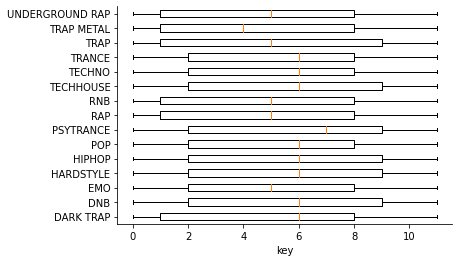

data: [[-7.364, -9.01, -9.988, -6.391, -7.9, -8.92, -10.196, -8.899, -7.492000000000001, -9.595, -4.935, -9.926, -10.498, -9.531, -13.774, -4.038, -6.2810000000000015, -7.479, -11.117, -7.646, -4.9110000000000005, -6.635, -9.335, -9.372, -9.419, -10.956, -3.962, -3.888, -5.038, -6.35, -9.607, -7.245, -7.485, -7.757999999999999, -8.173, -11.668, -12.675999999999998, -12.538, -13.823, -13.892, -13.754, -18.103, -11.345999999999998, -16.118, -11.363, -11.158, -14.777, -9.925, -8.521, -14.239, -12.783, -6.013, -15.274, -14.948, -8.932, -11.952, -9.729, -9.84, -8.978, -10.347, -13.925, -9.101, -10.233, -7.098, -10.368, -10.023, -12.496, -19.684, -10.158, -6.472, -6.062, -5.375, -5.888, -5.5920000000000005, -6.89, -7.58, -8.579, -10.987, -5.272, -8.134, -7.291, -6.142, -8.302, -8.343, -7.495, -11.643, -8.937000000000003, -4.396, -5.815, -10.419, -7.306, -6.5, -6.9670000000000005, -5.0139999999999985, -5.409, -6.3679999999999986, -6.142, -7.371, -8.626, -5.6960000000000015, -3.69, -8.843, -8.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


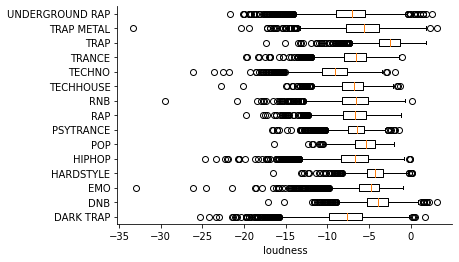

data: [[1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


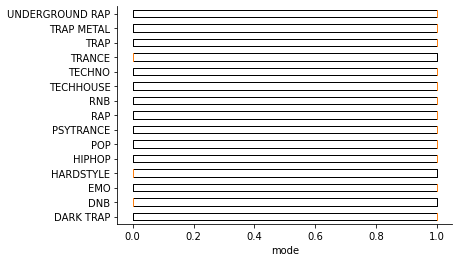

data: [[0.42, 0.0327, 0.0399, 0.111, 0.0767, 0.0408, 0.0344, 0.0462, 0.0381, 0.0326, 0.0412, 0.0968, 0.0383, 0.0815, 0.0393, 0.0794, 0.0753, 0.0488, 0.0386, 0.0398, 0.034, 0.0322, 0.069, 0.128, 0.0289, 0.045, 0.0622, 0.0396, 0.0396, 0.0466, 0.0367, 0.153, 0.0364, 0.0421, 0.0483, 0.04, 0.0487, 0.0354, 0.0844, 0.0262, 0.0337, 0.0577, 0.0303, 0.0372, 0.032, 0.0354, 0.034, 0.0609, 0.0308, 0.0733, 0.0412, 0.0383, 0.0362, 0.0374, 0.0364, 0.0344, 0.0304, 0.0384, 0.029, 0.0345, 0.0856, 0.035, 0.035, 0.0389, 0.174, 0.0309, 0.0315, 0.031, 0.0439, 0.0348, 0.0374, 0.0455, 0.0353, 0.0701, 0.171, 0.0348, 0.0399, 0.0478, 0.0327, 0.0472, 0.0345, 0.0271, 0.0351, 0.0348, 0.133, 0.0358, 0.12, 0.0305, 0.0338, 0.0405, 0.0387, 0.0597, 0.0341, 0.0492, 0.0315, 0.0709, 0.0271, 0.0359, 0.0294, 0.033, 0.0536, 0.0265, 0.057, 0.025, 0.234, 0.0386, 0.0445, 0.0367, 0.05, 0.154, 0.0541, 0.203, 0.0383, 0.0385, 0.0551, 0.05, 0.0299, 0.0354, 0.0283, 0.0488, 0.105, 0.0478, 0.0352, 0.0283, 0.102, 0.0518, 0.0246, 0.0358, 0

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


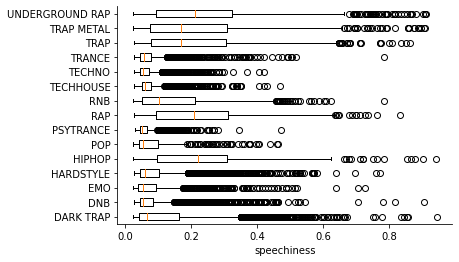

data: [[0.0598, 0.00807, 0.00855, 0.000601, 0.0285, 0.14400000000000002, 0.0749, 0.12, 0.00706, 0.00192, 0.0122, 0.18, 0.000199, 0.0534, 0.217, 0.0191, 0.0257, 0.00114, 0.922, 0.516, 0.00225, 0.000174, 0.0266, 0.0551, 0.0355, 0.34600000000000003, 0.0457, 0.021, 0.0176, 0.0254, 0.105, 0.014, 0.0025800000000000003, 0.00104, 0.0164, 0.0502, 0.261, 0.00542, 0.0988, 0.0931, 0.0943, 0.233, 0.366, 0.34700000000000003, 0.297, 0.0545, 0.0472, 0.0075, 0.00196, 0.206, 0.0185, 0.000193, 0.6990000000000001, 0.099, 0.0287, 0.00186, 0.0179, 0.00094, 0.00595, 0.0242, 0.192, 0.0149, 0.000278, 7.32e-05, 0.0013, 0.00579, 0.0113, 0.14800000000000002, 0.0532, 0.0593, 6.790000000000001e-05, 0.0201, 0.00179, 0.00275, 0.24, 0.174, 0.223, 0.0956, 0.026, 0.00197, 0.0306, 0.311, 0.322, 0.0895, 0.599, 0.0333, 0.121, 0.393, 0.0282, 0.0504, 0.255, 0.0161, 0.204, 0.0738, 0.0006190000000000001, 0.00221, 0.311, 0.0007650000000000001, 0.0251, 0.00238, 0.435, 0.0342, 0.8640000000000001, 0.662, 0.113, 0.0063, 0.800999999

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


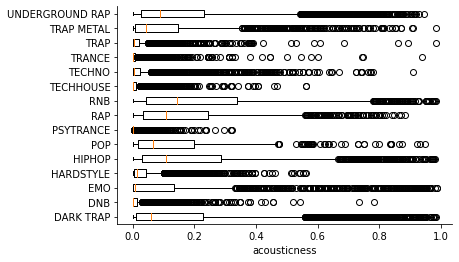

data: [[0.0134, 0.935, 0.595, 0.32, 0.0414, 0.888, 0.8440000000000001, 0.0696, 0.115, 0.502, 0.412, 0.0338, 0.877, 0.006659999999999999, 0.89, 0.748, 0.858, 0.897, 0.945, 0.107, 0.0858, 0.466, 0.75, 0.359, 0.154, 0.5489999999999999, 1.86e-05, 0.277, 0.615, 0.747, 0.233, 0.145, 0.5760000000000001, 0.0282, 0.878, 0.125, 0.89, 0.8170000000000001, 0.878, 0.915, 0.8029999999999999, 0.895, 0.93, 0.911, 0.8590000000000001, 0.341, 0.807, 0.908, 0.883, 0.89, 0.389, 0.851, 0.923, 0.8640000000000001, 0.484, 0.738, 0.852, 0.652, 0.0404, 0.542, 0.775, 0.633, 0.897, 0.8340000000000001, 0.42, 0.0956, 0.8640000000000001, 0.879, 0.86, 0.8029999999999999, 0.182, 0.132, 0.795, 0.8690000000000001, 0.93, 0.922, 0.883, 0.884, 0.945, 0.83, 0.883, 0.8009999999999999, 0.846, 0.00121, 0.496, 0.929, 0.917, 0.241, 0.923, 0.00498, 0.515, 0.38, 0.325, 0.172, 0.8059999999999999, 0.856, 0.8009999999999999, 0.7809999999999999, 0.948, 0.895, 0.88, 0.949, 0.946, 0.989, 0.635, 0.47, 0.87, 0.726, 0.0549, 0.0374, 0.201, 0.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


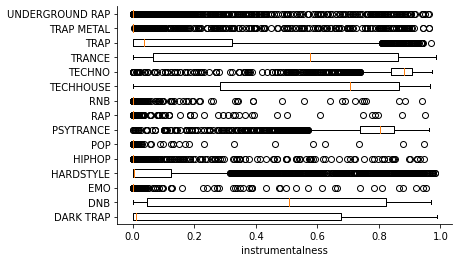

data: [[0.0556, 0.101, 0.0956, 0.0818, 0.295, 0.117, 0.103, 0.112, 0.0896, 0.129, 0.297, 0.0591, 0.5589999999999999, 0.0993, 0.121, 0.238, 0.0816, 0.0718, 0.0985, 0.0741, 0.426, 0.421, 0.121, 0.134, 0.358, 0.105, 0.0929, 0.0714, 0.13, 0.37, 0.204, 0.297, 0.226, 0.0967, 0.825, 0.0739, 0.0698, 0.124, 0.108, 0.0732, 0.0954, 0.0823, 0.0933, 0.071, 0.119, 0.0664, 0.12, 0.706, 0.09, 0.0814, 0.0804, 0.374, 0.0805, 0.106, 0.102, 0.0973, 0.232, 0.126, 0.0984, 0.0927, 0.08800000000000001, 0.0849, 0.317, 0.111, 0.333, 0.0805, 0.08900000000000001, 0.0829, 0.085, 0.518, 0.191, 0.165, 0.0728, 0.28600000000000003, 0.103, 0.118, 0.18, 0.111, 0.103, 0.129, 0.208, 0.127, 0.0855, 0.121, 0.0946, 0.07400000000000001, 0.155, 0.141, 0.528, 0.117, 0.122, 0.275, 0.138, 0.29, 0.0636, 0.121, 0.127, 0.123, 0.0831, 0.0803, 0.129, 0.108, 0.0981, 0.206, 0.13699999999999998, 0.38, 0.105, 0.109, 0.371, 0.136, 0.115, 0.107, 0.102, 0.0851, 0.112, 0.0834, 0.5870000000000001, 0.215, 0.109, 0.113, 0.135, 0.241, 0.0911, 0.2

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


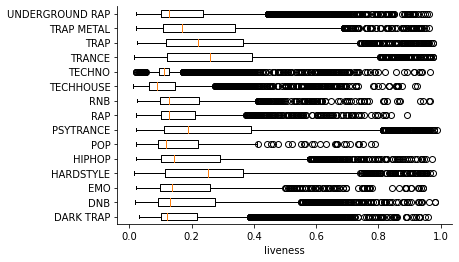

data: [[0.389, 0.12, 0.0889, 0.22, 0.324, 0.0583, 0.175, 0.259, 0.28600000000000003, 0.034, 0.473, 0.0991, 0.313, 0.189, 0.0754, 0.56, 0.191, 0.333, 0.0363, 0.12, 0.491, 0.37, 0.14800000000000002, 0.325, 0.0379, 0.0456, 0.194, 0.139, 0.0821, 0.575, 0.0379, 0.307, 0.0394, 0.0912, 0.0381, 0.0732, 0.483, 0.115, 0.312, 0.0733, 0.0762, 0.236, 0.155, 0.0395, 0.584, 0.0923, 0.175, 0.465, 0.0736, 0.206, 0.35, 0.0395, 0.123, 0.0379, 0.18600000000000005, 0.0538, 0.13, 0.0335, 0.101, 0.147, 0.115, 0.0344, 0.0559, 0.0747, 0.141, 0.179, 0.07, 0.0615, 0.14, 0.0304, 0.053, 0.0905, 0.237, 0.614, 0.0428, 0.0459, 0.126, 0.101, 0.263, 0.0317, 0.199, 0.419, 0.0391, 0.0398, 0.0393, 0.0741, 0.213, 0.306, 0.191, 0.325, 0.11, 0.0918, 0.121, 0.17, 0.0735, 0.131, 0.419, 0.077, 0.0347, 0.135, 0.359, 0.0927, 0.491, 0.106, 0.0414, 0.215, 0.0395, 0.218, 0.0931, 0.151, 0.0916, 0.691, 0.0992, 0.174, 0.0582, 0.0385, 0.0373, 0.0657, 0.0766, 0.103, 0.0773, 0.102, 0.0914, 0.092, 0.0915, 0.121, 0.18, 0.583, 0.104, 0.0795,

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


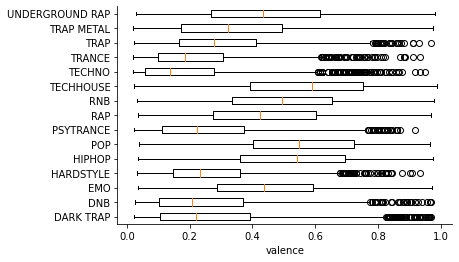

data: [[156.985, 119.991, 126.025, 126.049, 159.99200000000005, 119.973, 120.038, 141.87, 219.96, 220.044, 123.955, 219.97, 125.03, 145.061, 125.015, 159.97899999999996, 129.863, 140.017, 167.454, 130.01, 139.966, 140.055, 140.003, 139.997, 151.749, 139.998, 145.047, 140.025, 129.983, 139.97299999999998, 177.06799999999996, 139.99200000000002, 139.969, 117.01, 200.019, 150.276, 140.005, 133.033, 120.021, 216.04, 194.05, 120.002, 220.038, 127.996, 137.959, 220.1, 180.02, 119.979, 115.026, 150.678, 130.015, 139.93200000000002, 150.015, 180.071, 120.016, 112.061, 193.952, 130.002, 129.959, 139.939, 114.96, 119.988, 159.972, 129.991, 129.954, 200.06, 200.02, 139.98, 124.969, 159.99, 139.98, 139.96200000000002, 179.99599999999995, 144.987, 128.0, 128.017, 119.965, 199.918, 129.999, 124.026, 139.993, 125.025, 123.994, 129.99200000000002, 124.094, 122.026, 121.995, 129.988, 129.994, 130.02100000000002, 119.996, 150.278, 190.03, 137.99200000000002, 140.036, 149.94899999999996, 125.025, 144.974

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


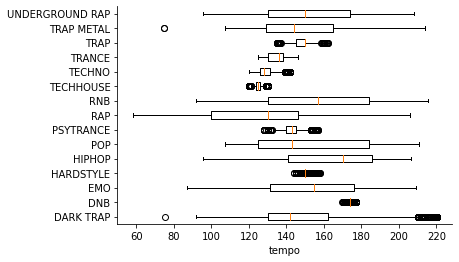

data: [[124539, 296020, 243853, 199147, 175672, 202005, 224016, 196562, 250812, 192017, 158720, 179903, 199690, 239172, 217965, 252013, 206864, 205714, 93094, 317538, 228107, 210857, 339429, 233143, 354638, 260571, 221793, 197156, 280615, 233143, 226244, 202286, 288000, 216398, 278126, 240457, 159478, 205766, 184476, 215980, 202997, 241998, 208770, 262505, 273084, 134609, 231105, 136019, 219585, 199105, 215902, 280594, 183144, 246622, 245368, 393300, 360229, 273293, 299572, 224601, 175334, 230000, 295745, 278769, 162462, 304800, 275106, 168124, 269774, 271594, 261094, 226286, 170764, 125793, 247500, 285000, 200625, 172825, 162462, 240039, 141429, 155520, 127791, 149538, 158746, 236066, 190851, 192000, 90462, 206769, 144000, 172800, 176842, 144348, 200000, 185652, 155520, 172138, 236382, 182124, 192034, 125910, 119172, 148154, 196667, 205270, 172800, 136699, 208965, 244804, 205166, 283000, 252800, 284000, 264020, 285800, 235200, 214154, 276000, 124594, 282094, 198094, 202800, 194292, 22

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


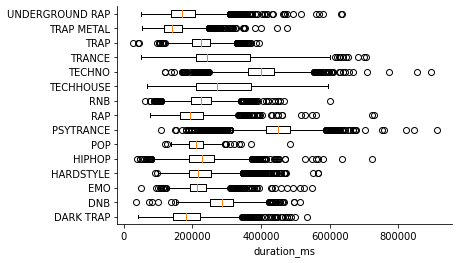

In [5]:
# Iterate through prep'd attribute-genre 2d array of metrics and data for boxplots
attr_str_index = 0
for attribute_metrics in all_attribute_genre_data:
  data = all_attribute_genre_data[attr_str_index]
  print('data:', data)
  medians = [ stats.median(branch) for branch in data ]
  plt.boxplot(
      data, vert=False
  )
  i = 0
  branch_labels = []
  for branch in data:
    max_value = max(branch)
    branch_labels.append(genres_list[i])
    i += 1
  axes = plt.gca()
  axes.spines['right'].set_visible(False)
  axes.spines['top'].set_visible(False)
  axes.set_yticklabels(branch_labels)
  plt.xlabel(attr_headers[attr_str_index])
  plt.show()
  attr_str_index += 1

## Histograms

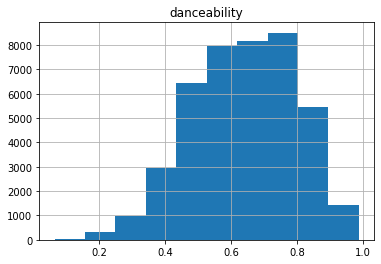

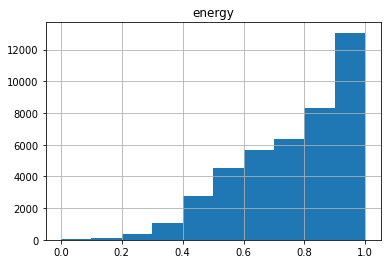

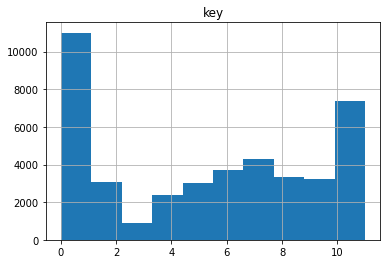

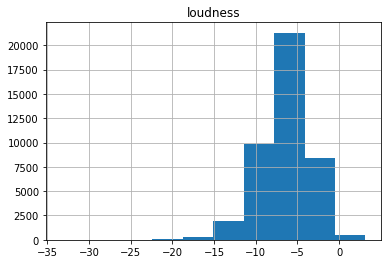

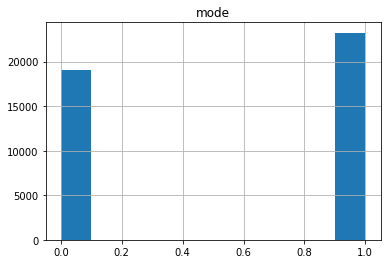

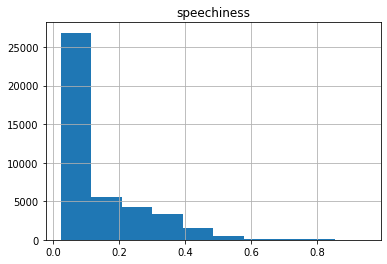

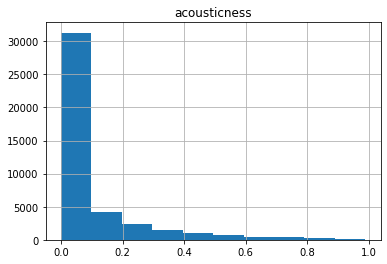

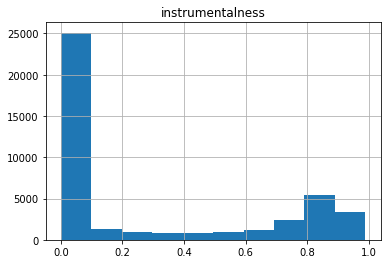

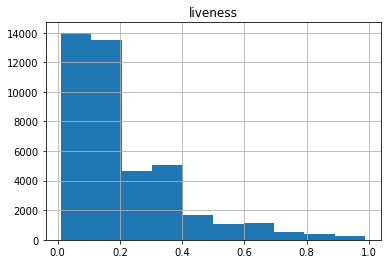

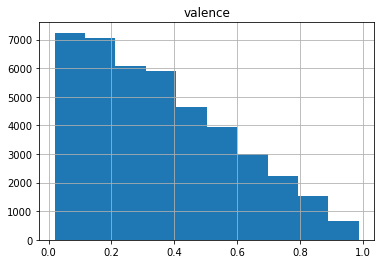

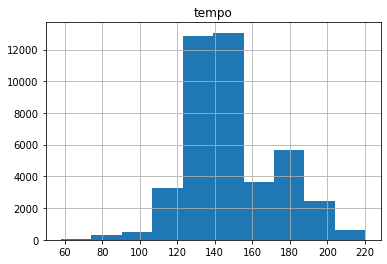

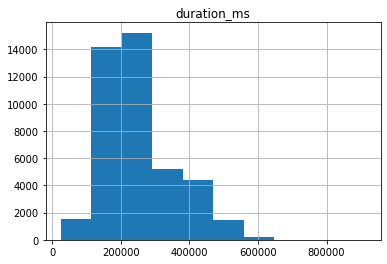

In [6]:
for attr in attr_headers:
  plt.figure()
  spotify_df[attr].hist()
  plt.title(attr)
  plt.show()

# **Correlation Analysis**

do at least one correlation analysis, like comparing speechiness and instrumentalness, for example.


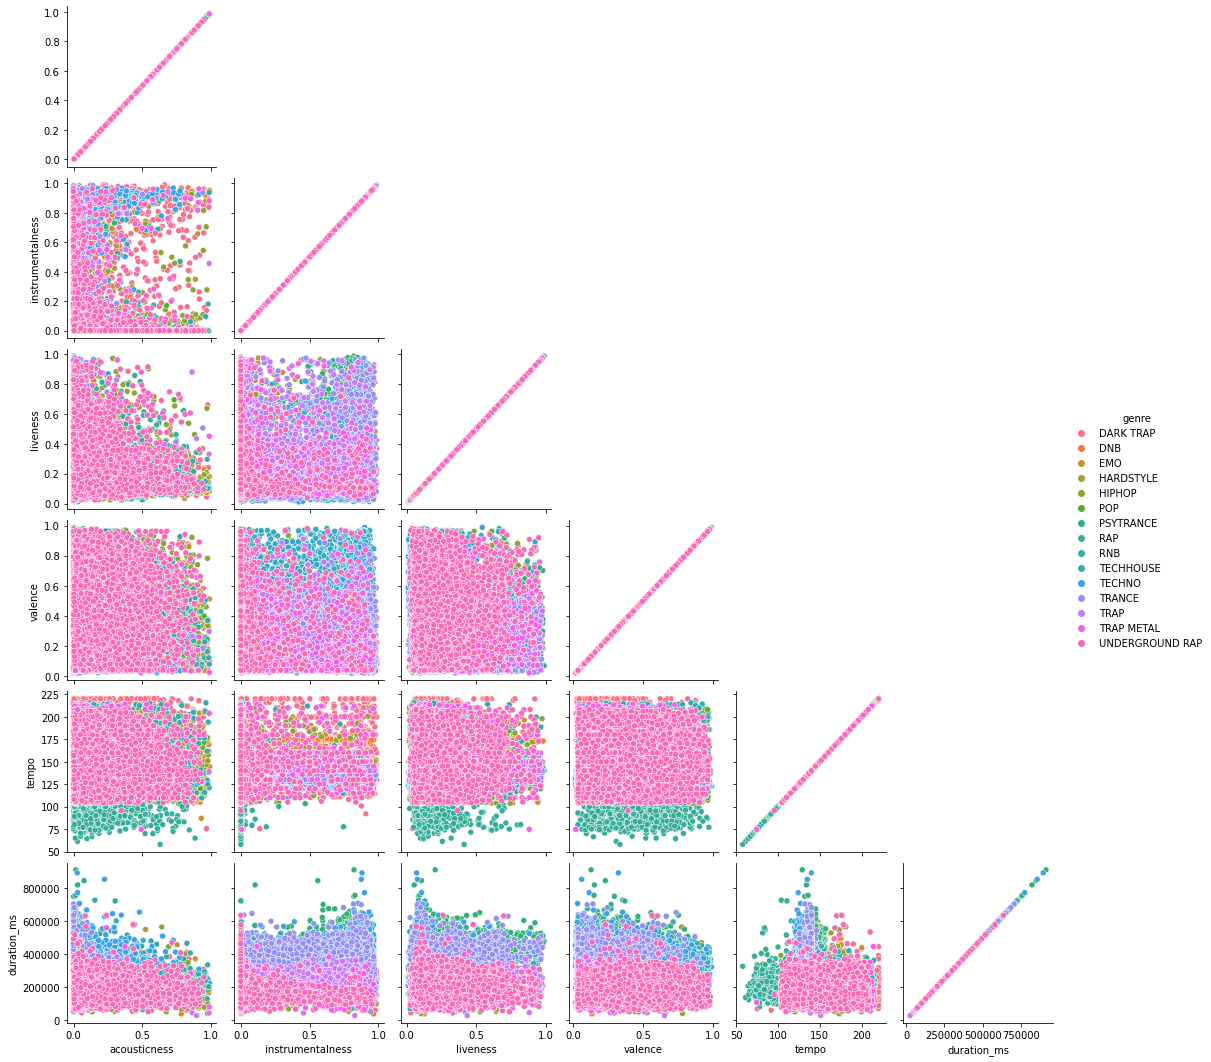

In [7]:
# Correlation analysis on last half of attributes
sb.pairplot(spotify_df.iloc[:, 6:], corner=True, diag_kind=None, hue='genre')

# **Classification**

show the code and results of 3 classification models based on decision tree inference, naive Bayes classification, and artificial neural networks; each classification model should be based on a consistent split between training and testing datasets; the accuracy of each model should be displayed; any specific tunning parameter used in a model should be supported by an explanatory text.


## Decision Tree



In [8]:
dt_columns = spotify_df.columns
feature_columns = dt_columns[0:-1]
X = spotify_df[feature_columns]
y = spotify_df.genre

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Decision Tree Accuracy:",metrics.accuracy_score(y_test, y_pred))


Decision Tree Accuracy: 0.5700441222817523


## Naive Bayes

In [9]:
gnb = GaussianNB() #Create a Gaussian Classifier

gnb.fit(X_train, y_train) #Train the model using the training sets

y_pred = gnb.predict(X_test) #Predict the response for test dataset

print("Naive Bayes Accuracy:",metrics.accuracy_score(y_test, y_pred)) # Model Accuracy, how often is the classifier correct?

Naive Bayes Accuracy: 0.49818783485660256


## Artifical Neural Network

In [10]:
from sklearn.neural_network import MLPClassifier 
from sklearn import preprocessing  
  
# Split the dataset into training and test dataset (assume the training set is 20% of the whole dataset)
df_train, df_test = train_test_split(spotify_df, test_size=0.3, random_state=0)

# Normalize attribute values first  
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(df_train.iloc[:,:-1].values)
X_test = min_max_scaler.fit_transform(df_test.iloc[:,:-1].values)
Y_train = df_train.iloc[:,-1].values
Y_test = df_test.iloc[:,-1].values

# Train a multilayer ANN to implement a hearts (disease) classifier
clf = MLPClassifier(max_iter=3000, random_state=0)
clf.fit(X_train, Y_train)

# Accuracy of the classifier
print('Artificial Neural Network Accuracy:', clf.score(X_test, Y_test))

Accuracy: 0.5586983926883076


## K-Nearest Neighbors

In [23]:
print("KNN performance before pipelining dataset:")
knn = KNeighborsClassifier().fit(X_train, y_train)
print('Accuracy: ' + str(knn.score(X_test,y_test)))

pipe = Pipeline([
('scaler', StandardScaler()),
('selector', VarianceThreshold()),
('classifier', KNeighborsClassifier())
])

pipe.fit(X_train, y_train)

print('\n\nKNN performance after pipelining dataset:')
print('Accuracy: ' + str(pipe.score(X_test,y_test)))

KNN performance before pipelining dataset:
Accuracy: 0.2956192877403089


KNN performance after pipelining dataset:
Accuracy: 0.5362433028679483
